In [1]:
import sys 
sys.path.remove('/usr/local/caffe/python')
sys.path.append('/raid/yaq007/yaqNIPS/kcaffe/python')

In [3]:
import os

import numpy as np
import os.path as osp
import matplotlib.pyplot as plt

from copy import copy


% matplotlib inline
plt.rcParams['figure.figsize'] = (6, 6)
    
caffe_root = '../'  # this file is expected to be in {caffe_root}/examples
sys.path.append(caffe_root + 'python')
import caffe # If you get "No module named _caffe", either you have not built pycaffe or you have the wrong path.

from caffe import layers as L, params as P # Shortcuts to define the net prototxt.

sys.path.append("pycaffe/layers") # the datalayers we will use are in this directory.
sys.path.append("pycaffe") # the tools file is in this folder

import tools #this contains some tools that we need

In [4]:
# set data root directory, e.g:
pascal_root = osp.join(caffe_root, '../../caffe/data/VOC/VOCdevkit/VOC2012')

# these are the PASCAL classes, we'll need them later.
classes = np.asarray(['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor'])

# make sure we have the caffenet weight downloaded.
os.path.isfile('/raid/yaq007/yaqNIPS/kcaffe/models/FCN-32s/fcn-32s-pascal.caffemodel')

# initialize caffe for gpu mode
caffe.set_mode_gpu()
caffe.set_device(0)

In [5]:
# helper function for common structures
def conv_relu(bottom, ks, nout, stride=1, pad=0, group=1):
    conv = L.Convolution(bottom, kernel_size=ks, stride=stride,
                                num_output=nout, pad=pad, group=group)
    return conv, L.ReLU(conv, in_place=True)

# another helper function
def fc_relu(bottom, nout):
    fc = L.InnerProduct(bottom, num_output=nout)
    return fc, L.ReLU(fc, in_place=True)

# yet another helper function
def max_pool(bottom, ks, stride=1):
    return L.Pooling(bottom, pool=P.Pooling.MAX, kernel_size=ks, stride=stride)

# main netspec wrapper
def caffenet_multilabel(data_layer_params, datalayer):
    # setup the python data layer 
    n = caffe.NetSpec()
    n.data, n.image_label, n.pixel_label = L.Python(module = 'pascal_ss_datalayers', layer = datalayer, 
                               ntop = 3, param_str=str(data_layer_params))

    # the net itself
    n.conv1_1, n.relu1_1 = conv_relu(n.data, 3, 64, pad=100)
    n.conv1_2, n.relu1_2 = conv_relu(n.relu1_1, 3, 64, pad=1)
    n.pool1 = max_pool(n.relu1_2, 2, stride=2)
    
    n.conv2_1, n.relu2_1 = conv_relu(n.pool1, 3, 128, pad=1)
    n.conv2_2, n.relu2_2 = conv_relu(n.relu2_1, 3, 128, pad=1)
    n.pool2 = max_pool(n.relu2_2, 2, stride=2)

    n.conv3_1, n.relu3_1 = conv_relu(n.pool2, 3, 256, pad=1)
    n.conv3_2, n.relu3_2 = conv_relu(n.relu3_1, 3, 256, pad=1)
    n.conv3_3, n.relu3_3 = conv_relu(n.relu3_2, 3, 256, pad=1)
    n.pool3 = max_pool(n.relu3_3, 2, stride=2)    
    
    n.conv4_1, n.relu4_1 = conv_relu(n.pool3, 3, 512, pad=1)
    n.conv4_2, n.relu4_2 = conv_relu(n.relu4_1, 3, 512, pad=1)
    n.conv4_3, n.relu4_3 = conv_relu(n.relu4_2, 3, 512, pad=1)
    n.pool4 = max_pool(n.relu4_3, 2, stride=2)     
    
    n.conv5_1, n.relu5_1 = conv_relu(n.pool4, 3, 512, pad=1)
    n.conv5_2, n.relu5_2 = conv_relu(n.relu5_1, 3, 512, pad=1)
    n.conv5_3, n.relu5_3 = conv_relu(n.relu5_2, 3, 512, pad=1)
    n.pool5 = max_pool(n.relu5_3, 2, stride=2)
    
    n.fc6, n.relu6 = conv_relu(n.pool5, 7, 4096)
    n.drop6 = L.Dropout(n.relu6, in_place=True)
    n.fc7, n.relu7 = conv_relu(n.drop6, 1, 4096)
    n.drop7 = L.Dropout(n.relu7, in_place=True)
    n.score_fr, n.relu8 = conv_relu(n.drop7, 1, 21)    
    
    n.upsample = L.Deconvolution(n.score_fr, num_output=21, kernel_size=64, stride=32)
    
    n.score = L.Crop(n.upsample, n.data)#, n.data)
    n.loss = L.Python(n.score, n.pixel_label, n.image_label, module = 'alaska_loss', layer = 'AlaskaLossLayer',  ntop = 1)
    
    return str(n.to_proto())

In [6]:
workdir = './secondNet'
if not os.path.isdir(workdir):
    os.makedirs(workdir)

solverprototxt = tools.CaffeSolver(trainnet_prototxt_path = osp.join(workdir, "trainnet.prototxt"), testnet_prototxt_path = osp.join(workdir, "valnet.prototxt"))
solverprototxt.sp['display'] = "1"
solverprototxt.sp['base_lr'] = "0.0001"
solverprototxt.write(osp.join(workdir, 'solver.prototxt'))

# write train net.
with open(osp.join(workdir, 'trainnet.prototxt'), 'w') as f:
    # provide parameters to the data layer as a python dictionary. Easy as pie!
    data_layer_params = dict(batch_size = 1, im_shape = [224, 224], split = 'train', pascal_root = pascal_root)
    f.write(caffenet_multilabel(data_layer_params, 'PascalMultilabelDataLayerSync'))

# write validation net.
with open(osp.join(workdir, 'valnet.prototxt'), 'w') as f:
    data_layer_params = dict(batch_size = 1, im_shape = [224, 224], split = 'val', pascal_root = pascal_root)
    f.write(caffenet_multilabel(data_layer_params, 'PascalMultilabelDataLayerSync'))

In [ ]:
solver = caffe.SGDSolver(osp.join(workdir, 'solver.prototxt'))
solver.net.copy_from(caffe_root + '/models/FCN-32s/fcn-32s-pascal.caffemodel')
solver.test_nets[0].share_with(solver.net)
solver.step(1)

BatchLoader initialized with 7 images
PascalMultilabelDataLayerSync initialized for split: train, with bs: 1, im_shape: [224, 224].
> /raid/yaq007/yaqNIPS/kcaffe/examples/pycaffe/layers/alaska_loss.py(64)setup()
-> self.n, self.num_L, self.w, self.h = bottom[0].data.shape
(Pdb) c
> /raid/yaq007/yaqNIPS/kcaffe/examples/pycaffe/layers/alaska_loss.py(75)reshape()
-> if bottom[0].count != bottom[1].count:
(Pdb) c
BatchLoader initialized with 7 images
PascalMultilabelDataLayerSync initialized for split: val, with bs: 1, im_shape: [224, 224].
> /raid/yaq007/yaqNIPS/kcaffe/examples/pycaffe/layers/alaska_loss.py(64)setup()
-> self.n, self.num_L, self.w, self.h = bottom[0].data.shape
(Pdb) c
> /raid/yaq007/yaqNIPS/kcaffe/examples/pycaffe/layers/alaska_loss.py(75)reshape()
-> if bottom[0].count != bottom[1].count:
(Pdb) c
> /raid/yaq007/yaqNIPS/kcaffe/examples/pycaffe/layers/alaska_loss.py(75)reshape()
-> if bottom[0].count != bottom[1].count:
(Pdb) c
> /raid/yaq007/yaqNIPS/kcaffe/examples/pycaf

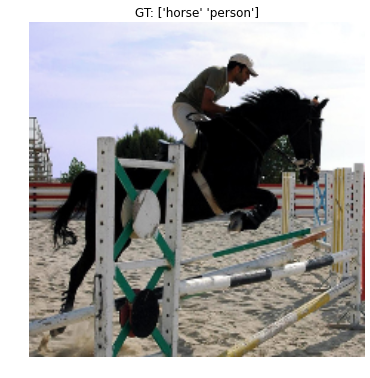

In [29]:
transformer = tools.SimpleTransformer() # This is simply to add back the bias, re-shuffle the color channels to RGB, and so on...
image_index = 0 # First image in the batch.
plt.figure()
plt.imshow(transformer.deprocess(copy(solver.net.blobs['data'].data[image_index, ...])))
gtlist = solver.net.blobs['label'].data[image_index, ...].astype(np.int)
plt.title('GT: {}'.format(classes[np.where(gtlist)]))
plt.axis('off');

In [30]:
def hamming_distance(gt, est):
    return sum([1 for (g, e) in zip(gt, est) if g == e]) / float(len(gt))

def check_accuracy(net, num_batches, batch_size = 128):
    acc = 0.0
    for t in range(num_batches):
        net.forward()
        gts = net.blobs['label'].data
        ests = net.blobs['score'].data > 0
        for gt, est in zip(gts, ests): #for each ground truth and estimated label vector
            acc += hamming_distance(gt, est)
    return acc / (num_batches * batch_size)

In [31]:
for itt in range(6):
    solver.step(100)
    print 'itt:{:3d}'.format((itt + 1) * 100), 'accuracy:{0:.4f}'.format(check_accuracy(solver.test_nets[0], 50))

KeyboardInterrupt: 

In [17]:
def check_baseline_accuracy(net, num_batches, batch_size = 128):
    acc = 0.0
    for t in range(num_batches):
        net.forward()
        gts = net.blobs['label'].data
        ests = np.zeros((batch_size, len(gts)))
        for gt, est in zip(gts, ests): #for each ground truth and estimated label vector
            acc += hamming_distance(gt, est)
    return acc / (num_batches * batch_size)

print 'Baseline accuracy:{0:.4f}'.format(check_baseline_accuracy(solver.test_nets[0], 5823/128))

Baseline accuracy:0.0004


IndexError: index 1 is out of bounds for axis 0 with size 1

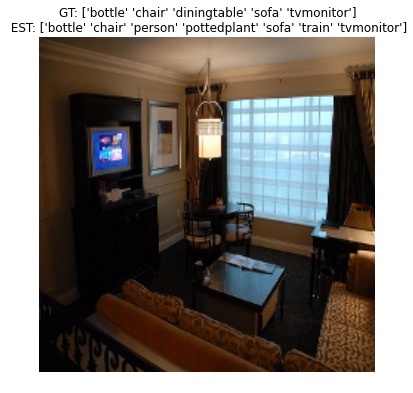

In [18]:
test_net = solver.test_nets[0]
for image_index in range(5):
    plt.figure()
    plt.imshow(transformer.deprocess(copy(test_net.blobs['data'].data[image_index, ...])))
    gtlist = test_net.blobs['label'].data[image_index, ...].astype(np.int)
    estlist = test_net.blobs['score'].data[image_index, ...] > 0
    plt.title('GT: {} \n EST: {}'.format(classes[np.where(gtlist)], classes[np.where(estlist)]))
    plt.axis('off')

In [8]:
from caffe import layers as L, params as P # Shortcuts to define the net prototxt.

In [13]:
L.Python.__doc__

In [11]:
L.Python(module = 'alaska_loss', layer = 'AlaskaLossLayer',  ntop = 1)